In [1]:
# Executing this cell will disable all TQDM outputs in stdout.
import os

os.environ["DISABLE_TQDM"] = "True"

# Computing multiple spectrograms with the Core API [^download]

[^download]: This notebook can be downloaded as **{nb-download}`example_multiple_spectrograms_core.ipynb`**.

Create an **OSEkit** `AudioDataset` from the files on disk, by directly specifying the time-related requirements in the constructor.

An `Instrument` can be provided to the `AudioDataset` for the WAV data to be converted in pressure units. This will lead the resulting spectra to be expressed in dB SPL (rather than in dB FS):

We will only use the **folder** in which the files are located: we don't have to dig up to the file level.

In [2]:
from pathlib import Path

audio_folder = Path(r"_static/sample_audio")

from osekit.core_api.audio_dataset import AudioDataset
from osekit.core_api.instrument import Instrument
from pandas import Timestamp, Timedelta

audio_dataset = AudioDataset.from_folder(
    folder=audio_folder,
    strptime_format="%y%m%d_%H%M%S",
    begin=Timestamp("2022-09-25 22:35:15"),
    end=Timestamp("2022-09-25 22:36:25"),
    data_duration=Timedelta(seconds=5),
    instrument=Instrument(end_to_end_db=150.0),
)

The `AudioDataset` object contains all the to-be-exported `AudioData`:

In [3]:
print(f"{' AUDIO DATASET ':#^60}")
print(f"{'Begin:':<30}{str(audio_dataset.begin):>30}")
print(f"{'End:':<30}{str(audio_dataset.end):>30}")
print(f"{'Sample rate:':<30}{str(audio_dataset.sample_rate):>30}")
print(f"{'Nb of audio data:':<30}{str(len(audio_dataset.data)):>30}")

###################### AUDIO DATASET #######################
Begin:                                   2022-09-25 22:35:15
End:                                     2022-09-25 22:36:25
Sample rate:                                           48000
Nb of audio data:                                         14


We also wanted to **skip** the `AudioData` that are **in the gap between recordings**.
Such `AudioData` have **no linked file**, thus their `is_empty` property should be `True`.

In [4]:
print(f"{' BEFORE FILTERING ':#^60}")
print(
    f"{'Nb of Empty data:':<30}{str(len([ad for ad in audio_dataset.data if ad.is_empty])):>30}\n"
)

# Remove the empty data by using the default AudioDataset constructor:
audio_dataset = AudioDataset([ad for ad in audio_dataset.data if not ad.is_empty])

##################### BEFORE FILTERING #####################
Nb of Empty data:                                          4



The `AudioData` should now only contain **non-empty `AudioData`**:

In [5]:
print(f"{' AFTER FILTERING ':#^60}")
print(f"{'Nb of audio data:':<30}{str(len(audio_dataset.data)):>30}")
print(
    f"{'Nb of Empty data:':<30}{str(len([ad for ad in audio_dataset.data if ad.is_empty])):>30}\n"
)

##################### AFTER FILTERING ######################
Nb of audio data:                                         10
Nb of Empty data:                                          0



Instantiate a `scipy.signal.ShortTimeFFT` FFT object with the required parameters:

In [6]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming

sft = ShortTimeFFT(
    win=hamming(1024),
    hop=128,
    fs=audio_dataset.sample_rate,
)

Create an **OSEkit** `SpectroDataset` from the `AudioDataset` and the `ShortTimeFFT` objects:

In [7]:
from osekit.core_api.spectro_dataset import SpectroDataset

spectro_dataset = SpectroDataset.from_audio_dataset(
    audio_dataset=audio_dataset,
    fft=sft,
    v_lim=(0.0, 150.0),  # Boundaries of the spectrograms
    colormap="viridis",  # Default value
)

We can plot a `SpectroData` object if we want to glance at the output before computing all spectrograms:

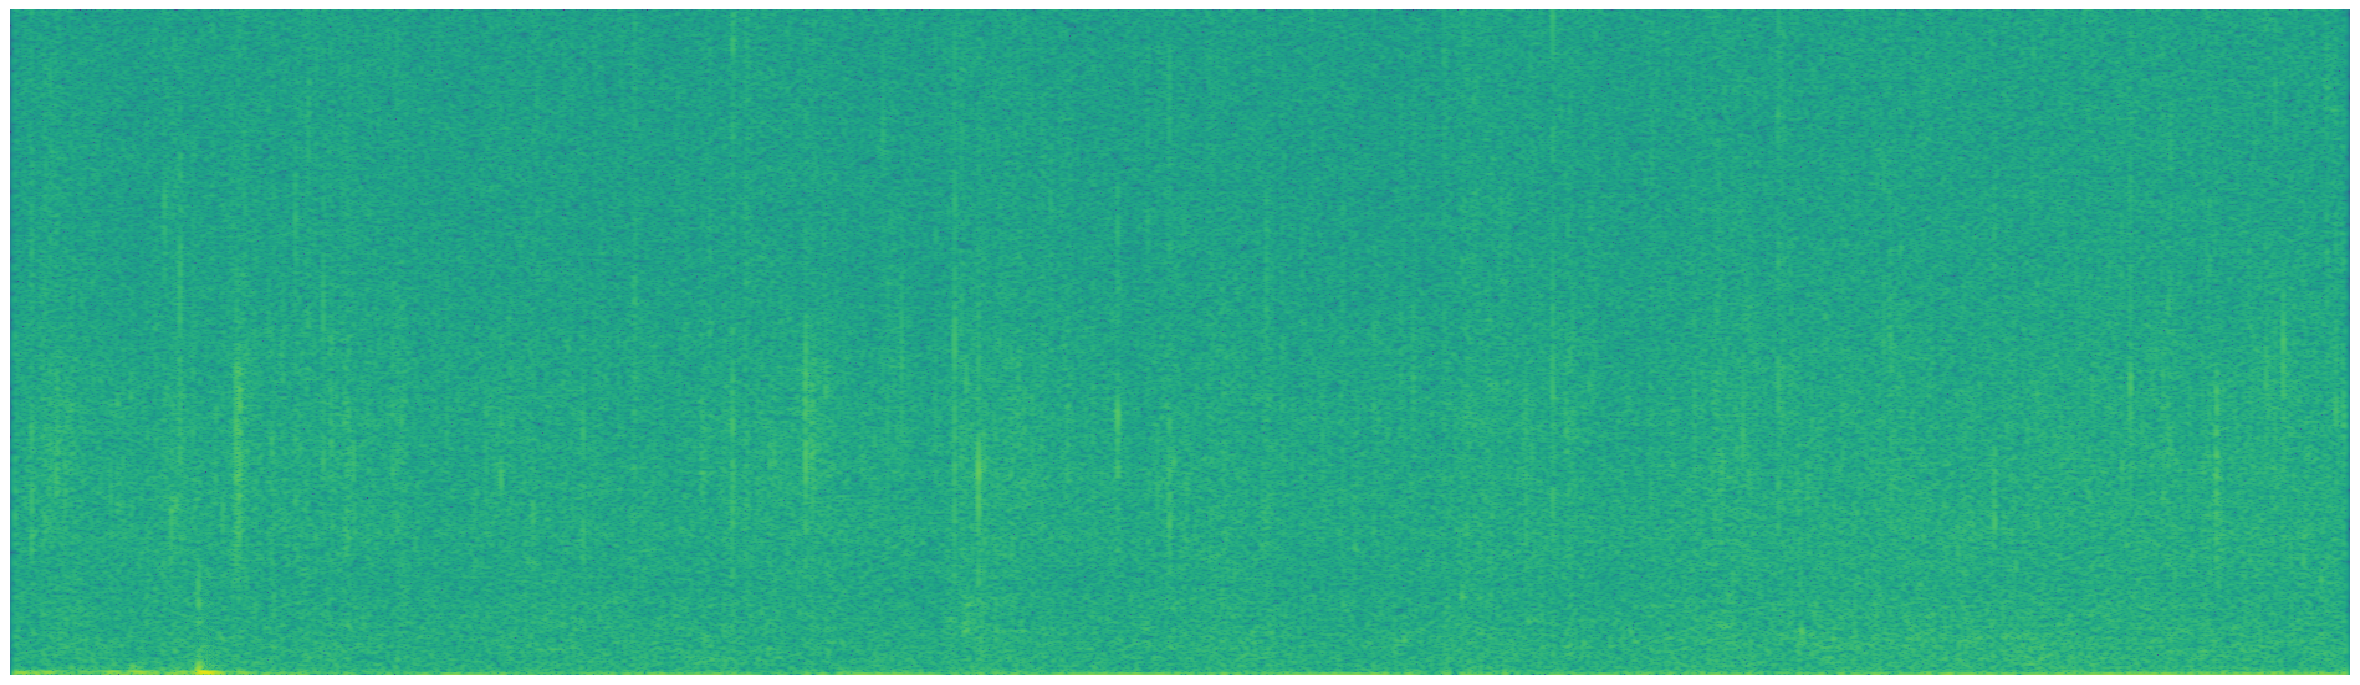

In [8]:
import matplotlib.pyplot as plt

spectro_dataset.data[0].plot()
plt.show()

We are now ready to export the spectrograms and matrices:

In [ ]:
# Export all spectrograms
spectro_dataset.save_spectrogram(folder=audio_folder / "spectrograms")

# Export all NPZ matrices
spectro_dataset.write(folder=audio_folder / "matrices")

## PSD estimates

We can also export Power Spectral Density estimates using the welch method:

In [ ]:
spectro_dataset.write_welch(folder=audio_folder / "welch")